# Neural style Transfer with PyTorch

you can take everyday images and convert them into artistic masterpieces. The neural style transfer algorithm was first presented in the following article by Gatys et al.: ***A Neural Algorithm of Artistic Style*** available [here](https://arxiv.org/abs/1508.06576).

In neural style transfer, **we take a content image and a style image. Then, we generate an image to have the content of the content image and the artistic style of the style image**. The algorithm is very intuitive to understand and follows the same concepts that we have been learning throughout this book, but with an added twist. By using the masterpieces of great artists as the style image, you can generate very interesting images, as we will see in this chapter

In this chapter, you will learn to implement the neural style transfer algorithm using PyTorch in order to generate artistic-looking images. You will learn about **content loss**, **style loss**, **Gram matrix**, and **how you can use them to implement the algorithm**.

## **Loading the data**

As mentioned previously, in a neural style transfer algorithm, we require at least a **content image** and **a style image**. In this recipe, we will first load the content and style images as PIL objects. Then, we will transform the PIL objects to PyTorch tensors so that we can feed them into the model. Then, we will display the tensors.

### **Getting ready**

For the steps in this chapter, you will need a content image and a style image. You can use the images provided with the scripts of this chapter or use any other images of your own. If you choose the latter, rename your images to `content.jpg` and `style.jpg` and put them into a folder named `data` in the same location of the scripts used in this chapter. The content image can be an everyday picture. For the style image, try to find an artistic image like the ones  on the [following web page](https://www.wikiart.org/) .

### **How to do it**

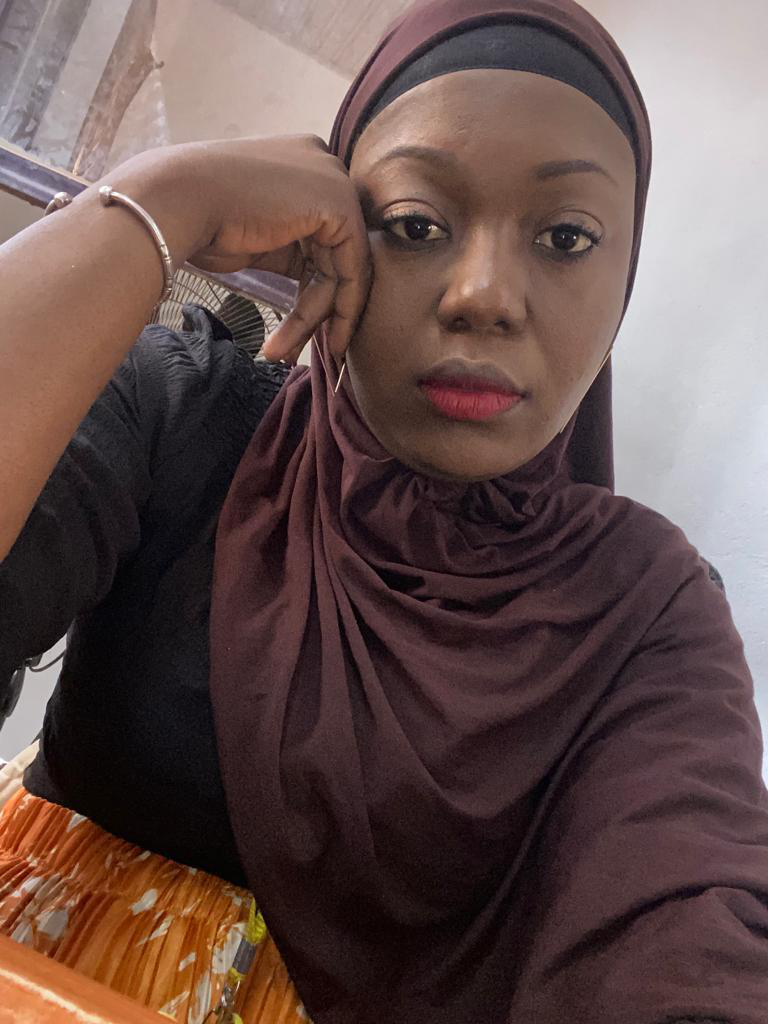

In [13]:
# 1 Load the content and style images:
from PIL import Image
path2content = "/content/data/content.jpg"
path2style = "/content/data/style.jpg"
content_img = Image.open(path2content)
style_img = Image.open(path2style)

# Display the content image:
content_img

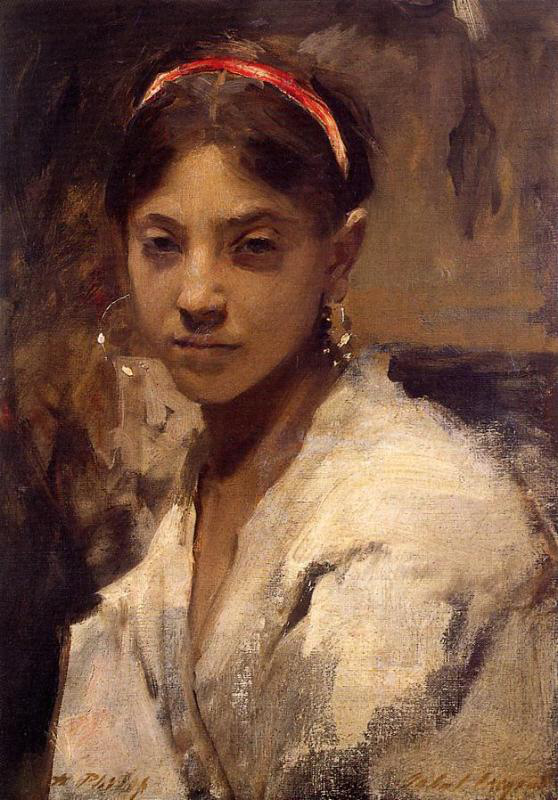

In [14]:
# Display the style image:
style_img

In [15]:
# 2 Define the image transformations as follows:
import torchvision.transforms as transforms

h, w = 256, 384 
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)]
    )
# 3 Transform the PIL images to tensors:
#Pass the content image to transformer:
content_tensor = transformer(content_img)
print(content_tensor.shape, content_tensor.requires_grad)

torch.Size([3, 1024, 768]) False


In [16]:
# Pass the style image to transformer:
style_tensor = transformer(style_img)
print(style_tensor.shape, style_tensor.requires_grad)

torch.Size([3, 800, 558]) False


Text(0.5, 1.0, 'content image')

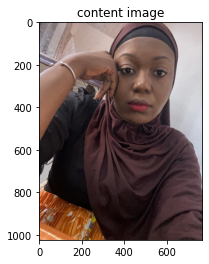

In [17]:
# 4 Display the content image after transformation:
# First, define a helper function to convert back tensors to PIL images:
import torch
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1, 1)
    img_tensor_c += torch.tensor(mean_rgb).view(3, 1, 1)
    img_tensor_c = img_tensor_c.clamp(0, 1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

# Then, call the helper function to display content_tensor:
plt.imshow(imgtensor2pil(content_tensor))
plt.title("content image")

Text(0.5, 1.0, 'style image')

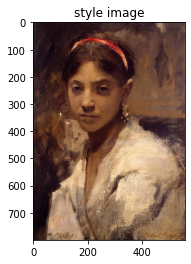

In [18]:
# Next, display style_tensor:
plt.imshow(imgtensor2pil(style_tensor))
plt.title("style image")

### **How it works**

In this recipe, we implemented the code to load the style and content images and transform them into tensors such that we can feed them into the model.

In step 1, we loaded the content and style images as `PIL` objects. We used the two images that were provided with the scripts of this chapter. However, you can replace them with your own content and style images. Make sure to copy the images into a folder named `data` in the same location as your scripts.

In step 2, we transformed the content and style images into tensors. To this end, we applied three transformations from the `torchvision.transforms` package: `Resize`, `ToTensor`, and `Normalize`. 

We used the `Resize` method to resize the images to $(256, 3384)$. Theoretically, you can use images of any size as the content and style images. In practice, these sizes are limited by the amount of memory available on your computer or CUDA device. Also, the higher image size will take a longer time to finish the algorithm.

We then converted `PIL` objects to PyTorch tensors using the `ToTensor` method. This function will scale the pixels' values to the range of $[0, 1]$. Next, we normalized the tensors by subtracting the RGB mean and dividing it by the RGB standard deviation (STD). The predefined RGB mean and standard deviation values depend on the pretrained model that you use for feature extraction. In our case, the VGG19 model was pretrained on the ImageNet dataset and the RGB mean and STD were obtained from the latter.

In step 3, we used the transformation function defined in step 2 to convert the content and style images to normalized tensors. Check out the tensor shape. As you can see, images were resized and reshaped into tensors of shape $[3, 256, 384]$. Also, check out the `requires_grad` attribute of the tensors. Since no optimization is applied to the content and style images, this attribute should be `False`.

In step 4, we displayed the content and style tensors. To be able to visualize the tensors, we defined the `imgtensor2pil` helper function to convert the tensors back to PIL images. Note that this helper function was defined for visualization purposes only. The input to the helper function is as follows:
* `img_tensor`: A PyTorch tensor of shape `[3, height, width]`
In the function, we first cloned the tensor to prevent making any changes to the original tensor. Since the tensor was previously normalized using the zero-mean-unit-variance normalization method, we renormalized it back to its original values. This was done by multiplying its values by the RGB standard deviation and then adding the RGB mean of the ImageNet dataset. Next, we made sure that the values are in the range $[0, 1]$ by using the `.clamp()` method. Finally, the tensor is converted to a `PIL` image using the `to_pil_image` function from the `torchvision` package.

## **Implementing neural style transfer**

As you have seen throughout this book, we have followed a few standard steps: we loaded the input and target data, defined a model, an objective function and optimizer, and then trained the model by updating the model parameters using the gradient-descent algorithm. In all of these past cases, the input to the model was kept unchanged during the training process and the model was updated.

Now, imagine a situation whereby we keep the model parameters fixed and instead update the input to the model during training. This twist is the intuition behind the neural style transfer algorithm.

Specifically, the neural style transfer algorithm works as follows:

* Take a pretrained classification model (for example, `VGG19`), remove the last layers, and keep the remaining layers to serve as a feature extractor.
* Feed the content image to the model and get selected features to serve as the target content.
* Feed the style image to the model and get the Gram matrix of selected features to serve as the target style.
* Feed the input to the model and get the features and the Gram matrix of selected features to serve as the predicted content and style, respectively.
* Compute the content and style errors, and use this information to update the input and reduce the error.
* Repeat step 4 until the error is minimized.
A block diagram of the neural style transfer algorithm is shown in the following screenshot:

![](model.png)

### **How to do it**

We will develop a neural style transfer algorithm. The algorithm has multiple steps and we will present each major step in a sub-recipe. 

#### **Loading the pretrained model**

We will load VGG19 as the pretrained model and freeze its parameters:

In [19]:
# 1 Load the pretrained
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()
print(model_vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [20]:
# 2 Freeze the model parameters: 
for param in model_vgg.parameters():
    param.requires_grad_(False)

#### **Defining loss functions**

We will define helper functions to **get the intermediate features from the model and compute the Gram matrix**. Then, **we will define the content loss and style loss**.

In [21]:
# 1 Define a helper function to get the outputs of intermediate layers:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

# 2 Define a helper function to compute the Gram matrix of a tensor:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h * w)
    gram = torch.mm(x, x.t())
    return gram

# 3 Define a helper function to compute the content loss:
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features [layer]
    loss = F.mse_loss(pred, target)
    return loss

# Define a helper function to compute the style loss:
def get_style_loss(pred_features, target_features, style_layers_dict):  
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix (target_features[layer])
        layer_loss = style_layers_dict[layer] *  F.mse_loss(pred_gram, target_gram)
        loss += layer_loss/ (n* c * h * w)
    return loss

# 5 Get the features for the content and style images:
feature_layers = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)
# For debugging purposes, let's print the shape of the content features:
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 1024, 768])
torch.Size([1, 128, 512, 384])
torch.Size([1, 256, 256, 192])
torch.Size([1, 512, 128, 96])
torch.Size([1, 512, 128, 96])
torch.Size([1, 512, 64, 48])


#### **Defining the optimizer**

First, we will initialize the input tensor and the optimizer:

In [22]:
# 1 Initialize the input tensor with the content tensor:
input_tensor = con_tensor.clone().requires_grad_(True)
# 2Define the optimizer:
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

#### **Running the algorithm**

We will run the neural style transfer algorithm to generate an artistic image:

In [23]:
# 1 Set the hyperparameters:
num_epochs = 1101
content_weight = 1e1
style_weight = 1e4
content_layer = "conv5_1"
style_layers_dict = {
    'conv1_1': 0.75,
    'conv2_1': 0.5,
    'conv3_1': 0.25,
    'conv4_1': 0.25,
    'conv5_1': 0.25
    }
# 2 Run the algorithm:
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers)
    content_loss = get_content_loss (input_features, content_features, content_layer)
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(epoch, content_loss, style_loss))

epoch 0, content loss: 0.0, style loss 7.8e+01
epoch 100, content loss: 0.77, style loss 1e+01
epoch 200, content loss: 0.83, style loss 8.0
epoch 300, content loss: 0.85, style loss 7.2
epoch 400, content loss: 0.87, style loss 6.8
epoch 500, content loss: 0.89, style loss 6.6
epoch 600, content loss: 0.9, style loss 6.4
epoch 700, content loss: 0.91, style loss 6.3
epoch 800, content loss: 0.91, style loss 6.2
epoch 900, content loss: 0.92, style loss 6.1
epoch 1000, content loss: 0.92, style loss 6.1
epoch 1100, content loss: 0.93, style loss 6.0


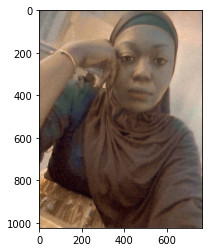

In [24]:
# 3 Display the result:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))

### **How it works**

In the Loading the pretrained model sub-section, we loaded a pretrained model to be used as the feature extractor.

As was observed in step 1, we used the VGG19 model from the `torchvision` package pretrained on the ImageNet dataset. The model expects the input to be mini-batches of shape `(3, Height, Width)` and normalized. This is why we transformed the content and style images in the Loading the data section.

In step 2, we froze the model parameters using the `requires_grad_` method to avoid any changes to the model during the algorithm optimization. 

In the Defining loss functions sub-section, we defined the content and style loss functions. To this end, we defined a few helper functions.

In step 1, we defined the `get_features` helper function. This helper function was developed to get the intermediate features of the pretrained model. These features will be used in calculating the style and content loss values. The inputs to the helper function are as follows:
* `x`: A PyTorch tensor of shape `[1, 3, height, width]`
* `model`: An object of the pretrained model
* `layers`: A Python dictionary, containing the layer names and numbers

In the helper function, we iterated over the model layers and passed the input tensor `x` to each layer and obtained its output. If the layer name is included in the `layers` dictionary, we collected its output. The helper function returns the collected features as a dictionary.

In step 2, we defined the `gram_matrix` helper function **to compute the Gram matrix of a tensor. The Gram matrix will be used to calculate the style loss value**. The function input is as follows:
* `x`: A tensor of shape `[1, c, h, w]`, where `c`, `h`, `w` are the *number of channels*, *height*, and *width* of `x`
  
The input tensor `x` comes from the intermediate features of the model. In the helper function, we reshaped `x` from a $4$D tensor to a $2$D tensor and then calculated the Gram matrix. The output is a tensor of shape `[c, c]`.

In step 3, we defined the `get_content_loss` helper function to compute the content loss value. The inputs to the helper function are as follows:

* `pred_features`: A Python dictionary containing the intermediate features of the model given the input tensor
* `target_features`: A Python dictionary containing the intermediate features of the model given the content tensor
* `layer`: A string containing the layer name

Like any typical loss function, here, we want to compute the distance between the target and predicted values. In the helper function, we extracted the target and predicted tensors for the layer specified by the argument `layer`. Then, we calculated the **mean squared error (MSE)** between the two tensors and returned its value.

In step 4, we defined the `get_style_loss` helper function to compute the style loss. The inputs to the helper function are as follows:

* `pred_features`: A Python dictionary containing intermediate features of the model given the input tensor
* `target_features`: A Python dictionary containing intermediate features of the model given the style tensor
* `style_layers_dict`: A Python dictionary containing the name and weight of the layers included in the style loss
In the helper function, we iterated over the style layers and extracted the predicted and target tensors per layer. Then, we calculated the Gram matrix for the two tensors and used them to compute the MSE. The loss value was calculated per layer, multiplied by the layer weight, normalized and then added all together. The function returned the accumulated loss value for all the layers included in the style loss.

In step 5, we called the `get_features` helper function to get the content and style features. To get the features, we passed the content tensor and style tensor to the helper function. Notice that we added a dimension to the tensors using the `.unsqueeze` method since the model input shape is `[1, 3, height, width]`. The name and number of the layers were defined in the Python dictionary, feature_layers. 

For debugging purposes only, we printed the shape of the content features in each layer.

In the Defining the optimizer sub-section, we defined the input tensor and optimizer to be able to update the input based on the loss values.

In step 1, we defined the input tensor. If you recall, the goal in the neural style transfer algorithm is to update the input to minimize the loss function. The input can be initialized randomly or with the content image. As was observed, we cloned the content tensor as the input tensor. Notice that the `requires_grad` method should be set to `True` since we want to be able to update the input tensor.

In step 2, we defined the optimizer. We chose the `Adam` optimizer from the `torch.optim` package. Notice that we passed `input_tensor` as the parameters to the optimizer. You can also use other optimizers available in the optim package, such as `LBFGS`.

In the Running the algorithm sub-section, we pieced together all the ingredients and executed the neural style transfer algorithm.

In step 1, we defined the hyperparameters. Check out the parameters, `content_weight` and `style_weight`. These parameters define the contributions of the content loss and style loss in the overall loss value. A higher `style_weight` parameter is usually desirable compared to `content_weight`, but you can play around with the values to see their contributions.

The `content_layer` parameter defines the name of the layer included in the content loss. Here, **we used `conv5_1` as the content layer**. You can set this parameter to a different layer and see the impact on the outcome.

The `style_layer_dict` parameter is a dictionary that defines the name and weight of the layers included in the style loss. As was observed, five layers were included. This parameter can also be changed as you desire. You can remove a layer from the dictionary or change the weights and get slightly different outcomes.

In step 2, with all the ingredients ready, we ran the complete neural style transfer algorithm. As was observed, the input tensor was passed to the `get_features` helper function and `input_features` was obtained. Note that `input_features` serves as the features predicted by the model. Then, we called the `get_content_loss` helper function to get `content_loss`. Next, we called the `get_style_loss` helper function to get `style_loss`. Then, the total loss was calculated by combining the content and style losses. Next, using the `.backward` method, the gradients of total loss with respect to the input tensor were calculated. Finally, the input tensor was updated using the `.step` method of the optimizer. 

As was observed, the optimizer updated the input tensor as the optimization progressed. The content loss started at zero since we initialized the input tensor with the content tensor and gradually increased. The style loss started at a higher value and gradually decreased as the input tensor was updated. 

In step 3, we displayed the outcome (`input_tensor`) once optimization was complete. Notice that we used the `imgtensor2pil` helper function to convert the tensor to a `PIL` image. As was observed, our neural style transfer algorithm worked and the resulting image got the texture of the style image.

You can now try using different images as the content or style images and generate new artistic images.

### **See also**

Instead of the `Adam` optimizer, you can use other optimizers such as `LBFGS`, as was proposed in the original paper.

Try LBFGS from the `torch.optim` package and see how it can impact the output.

Also, we initialized the input tensor with the content tensor. You can try initializing the input tensor with random values and rerun the algorithm. You may need to play around with the hyperparameters to get your desired outcome.

If you want to try different style images, check out the following links:

* https://www.wikiart.org/ 
* https://neuralstyle.art/styles

There are a few online websites and apps that provide style transfer services. Visit the following links:

* https://deepart.io/
* https://neuralstyle.art/